# Facemask detection using `Convolutional Neural Network` in `Python`


The `facemask lite` dataset on `Kaggle` contains `GAN-2` generated images of people with masks and without masks. Using that dataset, we trained a `Convolutional Neural Network` (CNN) to detect when someone is wearing a mask.
<br> 
We start by loading and preparing the dataset; then, we visualize the distribution of the images in the dataset.
<br> 
Next, we `build` the CNN model, `train` the model, then `evaluate` it.
<br> 
Finally, we apply the model to `predict` whether someone is wearing a mask or not.
<br>
<br>
Keywords: 
<br>`Data` 
<br>`Pytorch` 
<br>`Convolutional Neural Network` (CNN)
<br>`Deep Learning` 
<br>`Facemask`

### Preliminary steps

1. Download face mask lite dataset from kaggle
<br>Dataset source:  https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset
2. Unzip into folder named "data"
3. Separate data matching faces `with mask` and `without mask` into `training`, `validation`, and `testing` sets.

## `Kernel` preparation and `module` import

### Loading all nessesary `modules` and `libraries`.

In [1]:
# module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dill
import torch
from torchvision import datasets, transforms, utils
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix

### Using `dill` to save and load the kernel so not to loose trained model after kernel restart or system reboot.

In [1]:
# Load the saved session
#dill.load_session('notebook_env.db')

# Dataset preparation and data loading

First, we define data directories for `training`, `validation`, and `testing datasets`. <br>
The `training dataset` contains 7000 images of faces with masks and 7000 matching images of faces without masks. <br>
The `validation dataset` contains 2000 images of faces with masks and 2000 matching images of faces without masks. <br>
The `testing dataset` contains 1000 images of faces with masks and 1000 matching images of faces without masks. <br>
Then, we apply a transformation to the data to improve training. These transformations include `resizing`, `rotation`, `translation`, `flip`, and converting all images to `PyTorch tensors`. <br>
Finally, we use `ImageFolder` and provide it the appropriate `DataLoader`. `ImageFolder` takes a dataset and returns batches of images and corresponding labels.
<br>
<br>
Due to hardware limitations, available memory, and GPU performance, the following restrictions were implemented to the data.
<br>
The `training data` is reduced to 10000 images instead of the original 14000.
<br>
The `validation data` is reduced to 2000 images total instead of the original 4000.
<br>
The `testing data` is reduced to 1000 images total instead of the original 2000.

### Loading data directories.

In [2]:
train_data_dir = "data/train_dataset"
val_data_dir = "data/validation_dataset"
test_data_dir = "data/test_dataset"
full_data_dir = "data/full_dataset"

### Defining training variables.

In [13]:
batch_size_train = 64
batch_size_test = 1
batch_size = 1
image_size = 1024
num_epochs = 5

### Setting the GPU as the device training the model. Requires an NVIDIA GPU to be available.

In [4]:
# Using GPU for faster training
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 15, 'pin_memory': True} if device=='cuda' else {}
device

'cuda'

In [6]:
# System hardware profile
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060'

### Setting data transformations for training, validation, and testing dataset.

In [14]:
# Training dataset
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

# Validation dataset
val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    ])

# Testing dataset
test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    ])

# full dataset
full_transform = transforms.Compose([
    transforms.ToTensor(),
    ])


### Applying the transforms to the data.

In [15]:
# Training data
train_data = datasets.ImageFolder(train_data_dir, transform=train_transform)

# Validation data
val_data = datasets.ImageFolder(val_data_dir, transform=val_transform)

# Testing data
test_data = datasets.ImageFolder(test_data_dir, transform=test_transform)

# full data
full_data = datasets.ImageFolder(full_data_dir, transform=full_transform)

### Loading the data to the `dataloader`.

In [16]:
# Loading Training data
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train, shuffle=True, **kwargs)

# Loading Validation data
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, **kwargs)

# Loading Testing data
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, **kwargs)

# `Visualization` of the `distribution` of the full dataset

### Class and ID mapping of output.
Label `0` indicates the presence of a `facemask`, and label `1` indicates the absence of a `facemask`.

In [8]:
# Returns the class id present in the data
full_data.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [9]:
# construct a reverse of this dictionary, mapping of ID to class.
idx2class = {v: k for k, v in full_data.class_to_idx.items()}

### Visualization function
Define a function that takes in a `dataset object` and returns a dictionary that contains the count of `class` samples

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

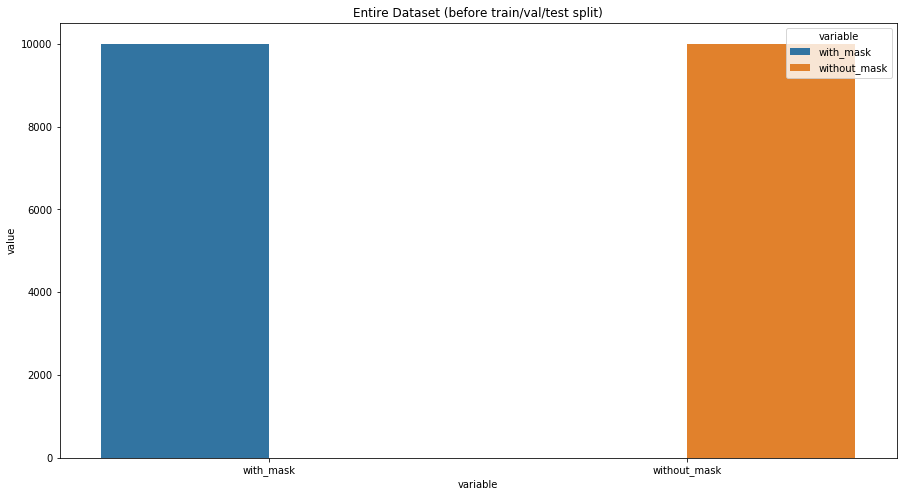

In [44]:
# Get class distribution
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

# Plot distribution
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(full_data), plot_title="Entire Dataset (before train/val/test split)")

### Define a function to display the images

In [33]:
# Function to show images
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()


### Retrieve the images and labels from the loader and display a training image batch.

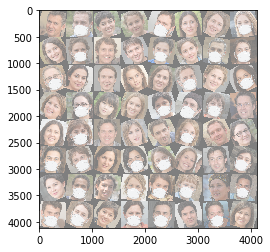

In [10]:
# Retreive images
images, labels = next(iter(train_loader))

# Display images
imshow(torchvision.utils.make_grid(images))

### Exploring an image, checking the `dimentions`, and `labels`

In [11]:
# Print first image dimentions
print(images[0].shape)

# Print first image label
print(labels[0])

torch.Size([3, 512, 512])
tensor(1)


In [12]:
# Save the session
dill.dump_session('notebook_env.db')

# Building the CNN with the `sequential` module

Our `CNN` is composed of three convolution layers, three `RELu` activation layers, three `batch normalization` layers and two `maxpooligng` layers for feature extraction. The fully connected (FC) layer has three linear layers and two RELu activation layer.
<br>
The architecture of our CNN is as follow.
<br>
2 X `convolution` + `maxpooligng` + `RELu activation` + `batch normalization`. 
<br>
1 X `convolution` + `RELu activation` + `batch normalization`.
<br>
2 X `FC layers` + `RELu activation`.
<br>
1 X `FC layer`.
Our CNN also implemented the `Sequential` module. We use one sequential module for the feature extraction and another sequential module for the fully connected layers.
<br>
<br>
Originally our neural network model had more layers. But because of hardware resource limitations and long training time, the neural layers have been reduced to the one described above.


### The `sequential` module - declaring the module and the `forward()` method

In [10]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        # Variables
        k_size = 3
        stride = 1
        padding = 1
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            # First convolutional layers
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 10),
            # Second convolutional layers
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 32),
            # Third convolutional layers
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=k_size, stride=stride, padding=padding),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 64),
            # Fourth convolutional layers
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=k_size, stride=stride, padding=padding),
            # # Max pooling layer
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # # ReLU nonlinearity
            # nn.ReLU(inplace=True),
            # # Batch Normalization
            # nn.BatchNorm2d(num_features = 128),
            # # Fith convolutional layers
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=k_size, stride=stride, padding=padding),
            # # Max pooling layer
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # # ReLU nonlinearity
            # nn.ReLU(inplace=True),
            # # Batch Normalization
            # nn.BatchNorm2d(num_features = 256)
        )
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(128 * 128 * 64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512), 
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    # Forward method
    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 128 * 128 * 64)
        # Classify the images
        x = self.classifier(x)
        return x




# Training the model
We instantiate our model, the cross-entropy loss function, and the adam optimizer function.
<br>
We train the model for five epochs printing the training loss for each epoch.

### Optimizer with L2-regularization and Loss Function

In [11]:
# Instantiate the network and move it to GPU
model = Net()
model.to(device)
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)

In [16]:
# Save the session
dill.dump_session('notebook_env.db')

In [17]:
# Lets look at the model
for n, p in model.named_parameters():
    print(p.device, "", n)

cpu  features.0.weight
cpu  features.0.bias
cpu  features.3.weight
cpu  features.3.bias
cpu  features.4.weight
cpu  features.4.bias
cpu  features.7.weight
cpu  features.7.bias
cpu  features.8.weight
cpu  features.8.bias
cpu  features.10.weight
cpu  features.10.bias
cpu  classifier.0.weight
cpu  classifier.0.bias
cpu  classifier.2.weight
cpu  classifier.2.bias
cpu  classifier.4.weight
cpu  classifier.4.bias


In [18]:
# keeping track of losses 
train_losses = []
valid_losses = []

print("starting training.")

for epoch in range(num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0

    # Training the model
    model.train()
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and moving data to GPU
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Release GPU memory
        torch.cuda.empty_cache()

        # Compute the forward pass
        outputs = model(inputs)
        
        # Compute the loss function
        loss = criterion(outputs, labels)
        
        # Compute the gradients
        loss.backward()
    
        # Update the weights
        optimizer.step()

        # update training loss
        train_loss += loss.item() * inputs.size(0)

        print("Training in progress ...")

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    # print training statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

print("Training completed")

.
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Epoch: 0 	Training Loss: 0.159519
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in progress ...
Training in pr

In [22]:
# Load the saved session
dill.load_session('notebook_env.db')

### Visualizing the training loss.

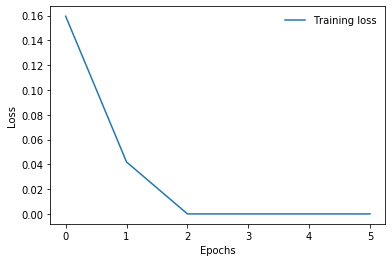

In [24]:
plt.plot(train_losses, label='Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [19]:
# Save the session after training
dill.dump_session('notebook_env.db')

In [23]:
# Release GPU memory
torch.cuda.empty_cache()

# Evaluating the model
We evaluate the model and print the final accuracy.


In [24]:
correct, total = 0, 0
predictions = []

model.eval()

# Iterate over the data in the test_loader
for i, data in enumerate(val_loader, 0):
  
    # Get the image and label from data
    images, labels = data

    # Move data to GPU if available
    images = images.to(device)
    labels = labels.to(device)
    
    # Make a forward pass in the net with your image
    outputs = model(images)
    
    # Argmax the results of the net
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # Print predictions
    if predicted == labels:
        print("Yipes, the net made the right prediction " + str(predicted))
    else:
        print("The net prediction was " + str(predicted) + ", but the correct label is: " + str(labels))

print("The testing set accuracy of the network is: %d %%" % (100 * correct / total))

rediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the right prediction tensor([1])
Yipes, the net made the 

### The `accuracy` of the model is very high (100%). Overfitting could be a factor in play. We will need the testing phase with unseen data to confirm the performance of the model. 

In [27]:
# Save the session with dill
dill.dump_session('notebook_env.db')

In [28]:
# Save the model
torch.save(model, "facemaskmodel.pth")

# Testing the model
After the training, we need to test how our model will perform with unseen data.
<br>
Before the testing, we disable back-propagation during the inference stage with `torch.no_grad()`

In [12]:
# Load the model
model = torch.load('facemaskmodel.pth')

In [17]:
# Define a list that will hold our prediction for each batch.
label_pred = []
label_true = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        # Get images and labels
        image_batch, true_label_batch = data

        # Sent to GPU
        image_batch.to(device)
        true_label_batch.to(device)

        # Make prediction
        label_test_pred = model(image_batch)

        _, label_pred_tag = torch.max(label_test_pred, dim = 1)

        # Convert to numpy object and append to the list
        label_pred.append(label_pred_tag.cpu().numpy())
        label_true.append(true_label_batch.cpu().numpy())

        print("Testing in progress")

Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress
Testing in progress


### Classification Report
Print out the `classification report`, which contains the `precision`, `recall`, and the `F1 score`.

Using the prediction and true label list as input for the `confusion_matrix` and the `classification_report`.

In [18]:
# Flatten the lists
label_pred = [i[0] for i in label_pred]
label_true = [i[0] for i in label_true]

In [19]:
print(classification_report(label_true, label_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### It seems our model is actualy very good and we acheive a `100% accuracy`.

### Confusion Matrix
Using the `confusion_matrix()` function to display the confusion matrix.

In [20]:
print(confusion_matrix(label_true, label_pred))

[[500   0]
 [  0 500]]


### Heatmap
We can create a dataframe from the `confusion matrix` and plot it as a `heatmap` using the `seaborn library`.

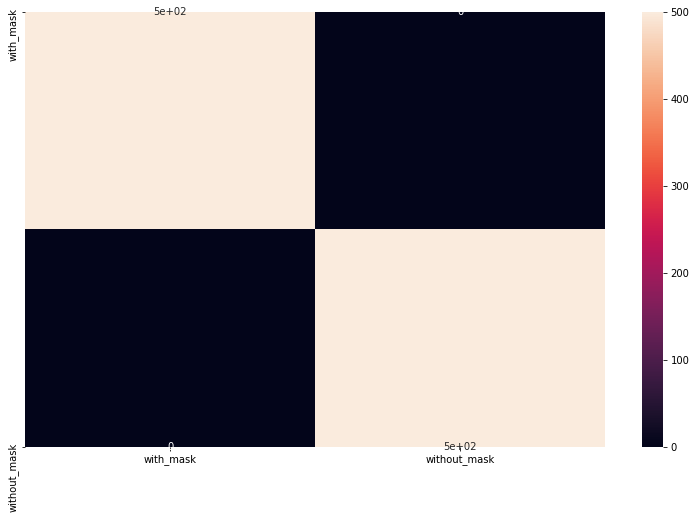

In [21]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(label_true, label_pred)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(13,8))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

### The `confusion matrix` shows that all our data has been properly predicted; the `true positives` and `true negatives`.

# The neural network `Model` in action
Let's apply the model by performing a `simple inference` on an image. For this, we will use our leftover dataset to select `random` images.

In [17]:
# Get dataset
data_dir = 'data/save_dataset'
save_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    ])

In [24]:
# Load model and check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('facemaskmodel.pth')
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1048576, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): 

Define a function that predicts the class of an image.

In [44]:
def predict_image_label(image):
    #image = image.to(device)
    output = model(image)
    _, label = torch.max(output.data, 1)
    return label

Define a function that chooses a random image from the saved dataset

In [45]:
data = datasets.ImageFolder(data_dir, transform=save_transforms)
classes = data.classes

def get_random_images(num):
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    images, labels = iter(loader).next()
    return images, labels

In [116]:

classes

['with_mask', 'without_mask']

Predict random image anf display the results.

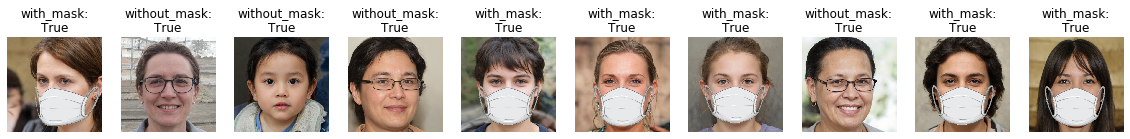

In [46]:
#model = model.to(device)
to_pil = transforms.ToPILImage()
num = 10
fig=plt.figure(figsize=(20,20))
for i in range(num):
    # get a random image
    images, labels = get_random_images(1)
    image = to_pil(images[0])
    # Predict image label
    index = predict_image_label(images)
    # Plot image and prediction
    sub = fig.add_subplot(1, num, i+1)
    res = int(labels[0]) == int(index)
    sub.set_title(str(classes[index]) + ":\n" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Conclusion

We have defined a `neural network model` that successfully predicts whether an individual is `wearing a mask or not`. Our model has achieved `100 % accuracy` and is validated by the testing and implementation phase.
<br>
<br>
Data preparation was a critical aspect of this model. A challenging part of this project was the choice of `hyperparameters` when building the model. Thankfully the course on `deep learning` with `PyTorch` on `Datacamp` and other classification projects helped determine the hyperparameters that worked with our model. Also, memory management issues with Pytorch prevented the use of the GPU for training. The available GPU (NVIDIA GeForce GTX 1060
) had only 6 GB of dedicated memory, whereas the training used more than 30 GB of memory.
<br>
<br>
Finally, all images used were generated by GAN-2. Consequently, bias presented in the data would also be reflected in our model. At first glance, the dataset had comprehensive coverage of the global population. Ideally, we would run a bias analysis on the dataset before implementation and explore the potential bias present in our model.
<br>
<br>
Potential application:
An implementation could connect the model to a camera feed to detect the presence of facemask on individuals before allowing them access to public spaces such as an ATM or similar public area to enforce social distancing guidelines during the pandemic.

### References
1. `Loading images using PyTorch`, Archit, Jul 12, 2019. <br>
https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2

2. `[PyTorch] 1. Transform, ImageFolder, DataLoader`, Jun, Apr 1, 2020. <br>
https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0

3. `A Comprehensive Guide to the DataLoader Class and Abstractions in PyTorch`, Vihar Kurama, Dec, 2020. <br>
https://blog.paperspace.com/dataloaders-abstractions-pytorch/

4. `PyTorch` documentation.<br>
https://pytorch.org/docs/0.3.0/index.html

5. `Datacamp`, Introduction to `Deep Learning` with `PyTorch`, 
https://campus.datacamp.com/courses/introduction-to-deep-learning-with-pytorch/

6. `How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images`, Chris Fotache, Nov 20, 2018 https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

7. `PyTorch [Vision] — Binary Image Classification`, Akshaj Verma, Apr 24, 2020 
https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9

8. Image Classification with PyTorch, Gaurav Singhal, Apr 1, 2020, 
https://www.pluralsight.com/guides/image-classification-with-pytorch
